# INF200 Lecture No 11
### 23 November 2014

## Today's topics

1. A bit more Pandas
    - Munching huge amounts of data: Trains in Germany
1. More cool stuff
    - Advances visualization tools
    - Road traffic in Britain
    - PV system modeling
1. A very short introduction to SymPy
1. Get it to run, get it right, **get it fast**
    - Benchmarking
    - Optimizing
    - Profiling

## 1. A bit more Pandas: Trains in Germany

- Daily data on most passenger trains in Germany is available from http://download.odcdn.de/zugsonar/
- Originated from [Zugmonitor Project by Süddeutsche Zeitung](http://www.sueddeutsche.de/thema/Bahn-Verspätungen)
- See also [Zugradar by Deutsche Bahn](http://www.bahn.de/p/view/buchung/auskunft/zugradar.shtml)
- Two files per day, with same data
    - tsv file: tab-separated values, one line per data point
    - json.stream file: each line is a valid JSON string representing one train's complete journey
- [7-zip](http://www.7-zip.org) required to unpack files
- We will use the tsv-file here
- Note: Files are *huge*, tsv-file is about 300 MB with over 2 million lines and about 20 columns

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 10)

### Initial exploration of the TSV-file

- We load only a few lines with Pandas
- NB: Due to its size, the file is not included in the repository. You need to download and unpack it yourself.

In [2]:
t = pd.read_csv('zugsonar.20151115.tsv', sep='\t', nrows=5, header=None)
print t

     0   1   2   3   4                   5         6                   7   \
0  2015  11  15   0   1  84/150595/18/19/80   RE 4434           Emden Hbf   
1  2015  11  15   0   1  84/147836/18/19/80  RE 26248           Emden Hbf   
2  2015  11  15   0   1  84/147800/18/19/80    ICE 26         Hamburg Hbf   
3  2015  11  15   0   1  84/145154/18/19/80  RE 14071       Osnabrück Hbf   
4  2015  11  15   0   1   84/67949/18/19/80   IC 2421  Frankfurt(Main)Hbf   

         8          9    ...     12  13  14          15     16  \
0  8.004031  53.182458   ...     13   4   0  2015-11-14  23:44   
1  7.386714  53.089671   ...      2   4   0  2015-11-14   0:00   
2  8.813689  53.083271   ...      3   3   0  2015-11-14  23:55   
3  8.510375  52.707387   ...      8   2   0  2015-11-14  23:51   
4  8.813689  53.083271   ...     12   5   0  2015-11-14  23:44   

                17       18     19                  20       21  
0  Bad Zwischenahn  8000770  23:50  Westerstede-Ocholt  8004610  
1   Pape

- Columns 0-4 are date and time
- Column 5 some identifier (assumed unique for a train run)
- Column 6 the train number (not necessarily unique)
- Column 7 Final destination
- Column 8, 9: longitude, latitude
- Columns 10-14: unknown information
- Columns 15-17: previous stop (date, time, station name, station id)
- Columns 18-21: next stop (date, time, station name, station id)

### Read all data

- Convert columns 0-4 to datetime objects `timestamp`
- Assign names to columns

In [3]:
t = pd.read_csv('zugsonar.20151115.tsv', sep='\t', header=None, 
                parse_dates={'timestamp': [0, 1, 2, 3, 4]},
                date_parser=lambda *pa: datetime(*[int(v) for v in pa]))
t.columns = ['timestamp', 'id', 'tr_num', 'dest', 'long', 'lat', 
             'u1', 'u2', 'u3', 'u4', 'u5', 
             'date_p', 'time_p', 'name_p', 'sid_p', 'time_n', 'name_n', 'sid_n']

In [4]:
print t.head()

            timestamp                  id    tr_num                dest  \
0 2015-11-15 00:01:00  84/150595/18/19/80   RE 4434           Emden Hbf   
1 2015-11-15 00:01:00  84/147836/18/19/80  RE 26248           Emden Hbf   
2 2015-11-15 00:01:00  84/147800/18/19/80    ICE 26         Hamburg Hbf   
3 2015-11-15 00:01:00  84/145154/18/19/80  RE 14071       Osnabrück Hbf   
4 2015-11-15 00:01:00   84/67949/18/19/80   IC 2421  Frankfurt(Main)Hbf   

       long        lat  u1  u2  u3  u4  u5      date_p time_p  \
0  8.004031  53.182458   8  14  13   4   0  2015-11-14  23:44   
1  7.386714  53.089671   8   6   2   4   0  2015-11-14   0:00   
2  8.813689  53.083271   1   2   3   3   0  2015-11-14  23:55   
3  8.510375  52.707387   8  20   8   2   0  2015-11-14  23:51   
4  8.813689  53.083271   2  21  12   5   0  2015-11-14  23:44   

            name_p    sid_p time_n              name_n    sid_n  
0  Bad Zwischenahn  8000770  23:50  Westerstede-Ocholt  8004610  
1   Papenburg(Ems)  800475

In [5]:
print t.shape

(2026934, 18)


- Over 2 million records reads

### Group data

- Each train reports data every few minutes, so there are many lines per train
- We now group the lines by the train-run id
- We do not group by train number, because that is not unique when a train run crosses midnight

In [6]:
trains = t.groupby('id')
len(trains)

27717

- We have a total of 27.717 individual train runs.
- Let's look at ICE 26

In [7]:
trains.get_group('84/147800/18/19/80')

timestamp                  id  tr_num         dest       long  \
2     2015-11-15 00:01:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
932   2015-11-15 00:02:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
1861  2015-11-15 00:03:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.891518   
1943  2015-11-15 00:03:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
2794  2015-11-15 00:04:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.923366   
2912  2015-11-15 00:04:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
3745  2015-11-15 00:05:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
4668  2015-11-15 00:06:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
5919  2015-11-15 00:07:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
6510  2015-11-15 00:08:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
7417  2015-11-15 00:09:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
8369  2015-11-15 00:10:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
9210  2015-11-15 00:11:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
10100 2015-11-15 00:12:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
10987 2015-11-15 00:13:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
11869 2015-11-15 00:14:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
12748 2015-11-15 00:15:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
13756 2015-11-15 00:16:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
14492 2015-11-15 00:17:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
15351 2015-11-15 00:18:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
16247 2015-11-15 00:19:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
17049 2015-11-15 00:20:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
17884 2015-11-15 00:21:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
18750 2015-11-15 00:22:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
19516 2015-11-15 00:23:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
20326 2015-11-15 00:24:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
21236 2015-11-15 00:25:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
21931 2015-11-15 00:26:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
22852 2015-11-15 00:27:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
23409 2015-11-15 00:28:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
24151 2015-11-15 00:29:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
25009 2015-11-15 00:30:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
25758 2015-11-15 00:31:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
26664 2015-11-15 00:32:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
27295 2015-11-15 00:33:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
27858 2015-11-15 00:34:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
28600 2015-11-15 00:35:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
29404 2015-11-15 00:36:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
30336 2015-11-15 00:37:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
30771 2015-11-15 00:38:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
31483 2015-11-15 00:39:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
32183 2015-11-15 00:40:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
32881 2015-11-15 00:41:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
33602 2015-11-15 00:42:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
34239 2015-11-15 00:43:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
34903 2015-11-15 00:44:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
35570 2015-11-15 00:45:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   8.813689   
36259 2015-11-15 00:46:00  84/147800/18/19/80  ICE 26  Hamburg Hbf   9.991914   
36867 2015-11-15 00:47:00  84/147800/18/19/80  

### Plotting train runs

- We need to convert position given as latitude and longitude to x-y-coordinates
- Matplotlib subpackage [basemap](http://matplotlib.org/basemap/) provides support for this (see also example on British road traffic below)
- I use a very naive approach here to obtain coordinates that are positive kilometer values from an arbitratily chosen reference point at $(2^{\circ}, 45^{\circ})$
- I assume that earth is a perfect sphere with circumference 40.000 km

In [8]:
t['x'] = 40000./360. * (t.long-2) * np.cos(np.pi/180. * t.lat)
t['y'] = 40000./360. * (t.lat-45)

- The following plotting code is very rough, essentially indicating my current limited knowledge of Pandas

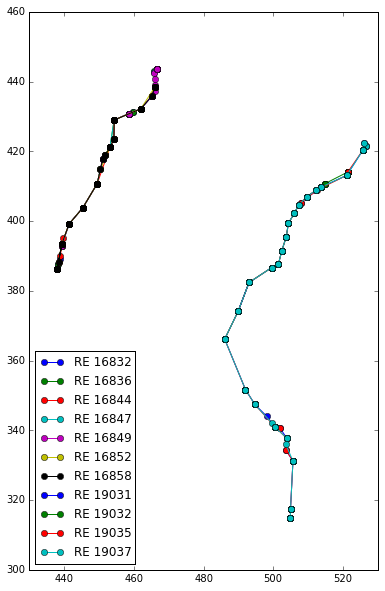

In [9]:
for idx, (train_id, train_data) in enumerate(trains):
    plt.plot(train_data.x, train_data.y, 'o-', label=train_data.tr_num.iloc[0]);
    if idx >= 10: break
plt.gca().set_aspect('equal');
plt.legend(loc='lower left');

- These seem to be two local train lines (RE: Regionalexpress) running roughly north-south over 60-120 km
- We can also plot some long-distance trains

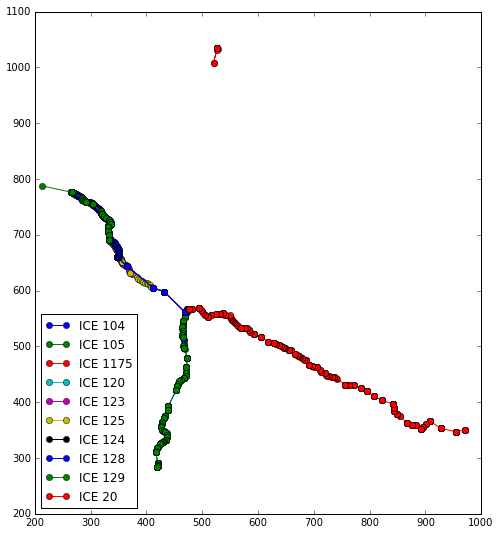

In [10]:
ctr = 0
for train_id, train_data in trains:
    if not train_data.tr_num.iloc[0].startswith('ICE'): continue
    plt.plot(train_data.x, train_data.y, 'o-', label=train_data.tr_num.iloc[0]);
    ctr += 1
    if ctr >= 10: break
plt.gca().set_aspect('equal');
plt.legend(loc='lower left');

- This looks like one ICE in the far north and most others further south
- Probably
    - Amsterdam-Cologne-Frankfurt-Basel
    - Frankfurt-Nürnberg-Passau

### Heat map: Where do trains travel in Germany?

- Create a sufficiently large matrix for a 1 km grid spanning Germany
- For each record in the dataset, add one to the current position of the train

In [11]:
print t.x.max(), t.y.max()

1062.02559641 1117.27622222


In [12]:
train_density = np.zeros((1100, 1150))
for x, y in zip(t.x, t.y):
    train_density[int(x), int(y)] += 1

- Since the density is very unevenly distributed, we plot on a logarithmic scale

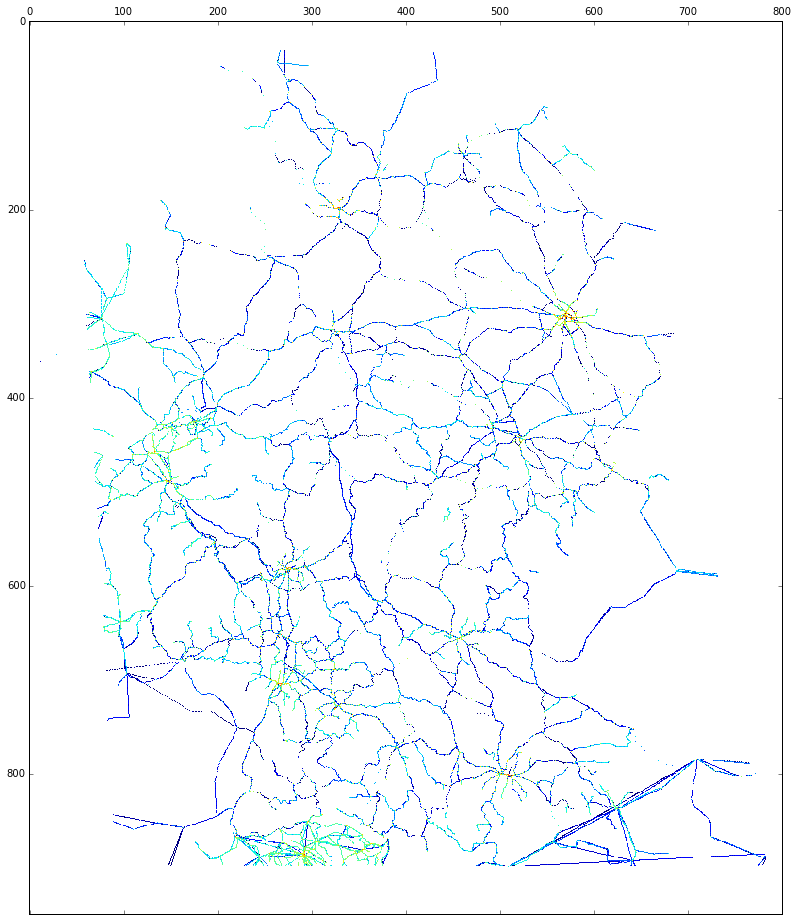

In [13]:
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = (10, 16)
plt.matshow(train_density.T[-1:-950:-1, 200:1000], norm=LogNorm(vmin=1, vmax=train_density.max()));

## 2. More cool stuff

- There is a *huge* and constantly growing ecosystem of Python tools for scientific purposes

### Advanced visualizaton tools

- Many of these build on Matplotlib
    - [Seaborn: Statistical Data Visualization](http://stanford.edu/~mwaskom/software/seaborn/)
    - [HoloViews: Composable, declarative data structures for building even complex visualizations easily](http://holoviews.org)
    - [Glue: Multidimensional data exploration](http://www.glueviz.org/en/stable/)
    - [MayaVi: 3D scientific data visualization and plotting in Python](http://docs.enthought.com/mayavi/mayavi/)
    - [Plotly: Commercial visualization tool](https://plot.ly)

### "Real world" data analysis

- [Processing the UK's real-time traffic data with Python](http://rjw57.github.io/blog/2013/06/19/real-time-traffic-data/)
    - Detailed tutorial on how to use publicly available traffic data to visualize traffic
    - Also available as [IPython Notebook](http://rjw57.github.io/blog/static/notebooks/realtime-traffic-data.ipynb)
        - Requires UK map [available here](https://gist.github.com/rjw57/5805059)
    - Similar data available for Norway from [Statens Vegvesen](http://www.vegvesen.no/data), unfortunately rather more difficult to access for beaurocratic reasons 

### Modeling PV systems

- [Sandia National Laboratory's PVLib](http://pvlib-python.readthedocs.org/en/latest/index.html)
- [Example IPython Notebook](http://nbviewer.ipython.org/github/pvlib/pvsc2015/blob/master/paper.ipynb)

## 3.  An even shorter introduction to SymPy

- [SymPy](http://www.sympy.org/en/index.html) provides *computer algebra* in Python
- It allows you to perform *symbolic* manipulations on mathematical expressions (instead of *numerical* calculations)
- Examples based on SymPy documentation

In [14]:
from sympy import *
init_printing(use_latex=True)

### Find the derivative of an expression

$$\frac{d}{dx} \sin(x) e^x$$

In [15]:
x = symbols('x')
diff(sin(x) * exp(x), x)

### Find the integral of an expression

$$\int e^x\sin x + e^x \cos x dx$$

In [16]:
integrate(exp(x) * sin(x) + exp(x) * cos(x), x)

### Some linear algebra

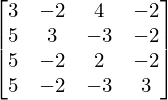

In [17]:
m = Matrix([[3, -2,  4, -2], [5,  3, -3, -2], [5, -2,  2, -2], [5, -2, -3,  3]])
m

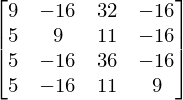

In [18]:
m * m

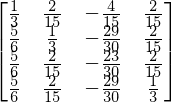

In [19]:
im = m**(-1)
im

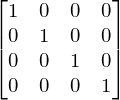

In [20]:
m * im

In [21]:
m.det()

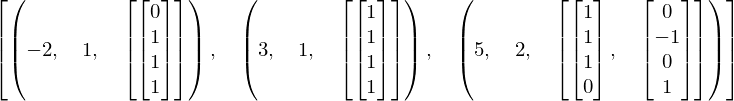

In [22]:
m.eigenvects()

## 4. Get it fast

One of the key ideas of Agile programming is to proceed as follows (Kent Beck):

1. Get it to work
1. Get it right
1. Get it fast

We have looked at the first two points, now we will turn to getting code fast.

### Why make it fast?
- Users do not like to wait: fast response times
    - E.g. Google: 10x faster than [AltaVista](https://en.wikipedia.org/wiki/AltaVista) and better results
    - Extreme case: [High-frequency trading](https://en.wikipedia.org/wiki/High-frequency_trading) on the stock market
- Science and engineering
    - Short turn-around times allow more experiments
    - Simulation experiments using months or years are often not useful
- Classic example: [US Census](http://www.census.gov/history/www/census_then_now/notable_alumni/herman_hollerith.html)
    - Performed every 10 years (required by US Constitution)
    - 1880 census was only completely evaluated in 1887
    - 1888 competition for automated tabulation
    - Won by Hermann Hollerith, used in 1890 census
    - Machines also used in 1891 Norwegian census
    - Developed into IBM
    
### How to make it fast?
- Use faster hardware
    - Can be costly
    - Not always available
    - Competition will also use faster hardware, so just faster hardware may not be enough
- Improve your software
    - Better algorithms
    - Smarter data structures
    - 90-10 rule: typically, 90% of the time is spent in 10% of the code
- Change your approach
    - Sometimes, chosing an entirely different strategy can provide faster or better results
    
### The pitfalls of optimization
- Wasting time on the wrong things
    - Donald Knuth: "We should forget about small efficiencies, say about 97% of the time: premature optimization is the root of all evil." [Wikipedia](https://en.wikipedia.org/wiki/Program_optimization)
- Trade-offs
    - "There is no such thing as a free lunch"
    - Memory: faster algorithms may need more
    - Flexibility: by limiting what code can do, we may make it faster
    - Portability: fine-tuning may make code faster on one machine, but it may no longer run on others
- Correctness
    - Optimization means changing code
    - Changes may break code
    - A thorough test regime needs to be in place *before* optimizing

## Algorithm analysis

### Summing numbers

Task: Compute the sum of all natural numbers up to $n$, i.e., $\sum_{k=1}^{n} k$.

#### Implementations

##### Loop

In [23]:
def sum_n_loop(n):
    s = 0
    for k in range(1, n+1):
        s += k
    return s

##### List comprehension over `range`

In [24]:
def sum_n_comp(n):
    return sum(range(1, n+1))

##### Comprehension over `xrange`

`xrange` does not create a list of numbers, it just returns one number at a time.

In [25]:
def sum_n_gen(n):
    return sum(xrange(1, n+1))

#### Tests

In [26]:
funcs = [sum_n_loop, sum_n_comp, sum_n_gen]
for func in funcs:
    assert func(1) == 1
    assert func(2) == 3
    assert func(3) == 6

#### Analysis

- How many operations are needed to complete the calculation?
- $n$ loop iterations
    - For each loop iteration
        - $1$ addition
        - $1$ step of the loop counter $k$
- Some operations to start function and return value
- Model of operation count
    - $a$ operations outside loop
    - $b$ operations inside loop for each iteration
    - $\Rightarrow a + b n$ operations
- Rough assumptions
    - All operations take the same time $c$
    - Then total time required: $T(n) \approx c(a+bn)$
    - For $n\gg 1$ we can ignore the constant, so $T(n)\sim n$ 
- The algorithm is *linear* in problem size
- In algorithm analysis, we say that the run-time is of order $n$, $T(n)\sim\mathcal{O}(n)$
- For details, see textbooks on algorithms and data structures

#### Algorithmic improvement

- From mathematics: $$\sum_{k=1}^n k = \frac{n(n+1)}{2}$$

##### Implementation based on analytical solution

In [27]:
def sum_n_ana(n):
    return (n * (n + 1)) / 2

##### Analysis of analytical-solution algorithm

- One addition, one multiplication, on division by $2$ *independent of problem size*
- $\Rightarrow T(n) = \mathrm{const}$ or $T(n)\sim\mathcal{O}(1)$
- Signficant improvement for $n\gg 1$
- Weaknesses
    - operations are only constant in time as long as integer type is fixed size
    - therefore, the analysis above holds strictly only up to a certain $n$
    - not a problem in Python, because integers grow as required

##### Re-run tests for all solutions

In [28]:
funcs = [sum_n_loop, sum_n_comp, sum_n_gen, sum_n_ana]
for func in funcs:
    assert func(1) == 1
    assert func(2) == 3
    assert func(3) == 6

### Sorting algorithms

Let us have quick look at sorting algorithms.

#### Bubble sort (see also EX03)

In [29]:
def bubble_sort(data):
    sdata = list(data)
    for j in reversed(range(len(sdata))):
            for k in range(j):
                if not sdata[k] <= sdata[k + 1]:
                    sdata[k], sdata[k + 1] = sdata[k + 1], sdata[k]

- Let $n=\mathrm{len}(\mathrm{data})$
- Outer loop: $n$ iterations
- Inner loop: $j$ iterations
    - $1$ comparison
    - possibly $1$ swap
- Total number of inner-loop iterations: 
  $$\sum_{j=1}^{n-1} j=\frac{n(n-1)}{2}\sim n^2 \quad \text{for} \; n\gg 1$$
- Algorithm's run-time is *quadratic* in problem size, $T(n)\sim n^2$ or $T(n)\sim \mathcal{O}(n^2)$

#### Quicksort

- Divide-and-conquer sorting algorithm: subdivide sort into smaller and smaller tasks
- Invented by [C.A.R. Hoare](https://en.wikipedia.org/wiki/Tony_Hoare) around 1959
- Still one of the most used sorting algorithms
- See e.g. [Wikipedia](https://en.wikipedia.org/wiki/Quicksort)
- Basic idea:
    1. Choose a pivot element from the data
    1. Re-order data so that
        - all elements smaller than pivot are left of the pivot
        - all elements larger than pivot are right of the pivot
    1. Apply recursively on left and right side

In [30]:
def quicksort(data):
    sdata = list(data)
    _quicksort(sdata, 0, len(sdata))
    return sdata

def _quicksort(data, left, right):
    if right - left < 2:
        return

    pivot_idx = _partition(data, left, right)
    _quicksort(data, left, pivot_idx)
    _quicksort(data, pivot_idx + 1, right)

def _partition(data, left, right):
    if not left < right:
        return None

    right -= 1  
    pivot_idx = left
    pivot_val = data[pivot_idx]

    data[pivot_idx], data[right] = data[right], data[pivot_idx]
    store_idx = left

    for i in range(left, right):
        if data[i] < pivot_val:
            data[i], data[store_idx] = data[store_idx], data[i]
            store_idx += 1
    data[store_idx], data[right] = data[right], data[store_idx]

    return store_idx

- All work is done in `_partition`
    - one loop of length `right-left` or $n = r-l$
- How do $l$ and $r$ change as recursion progresses?
- Best case:
    - pivot splits data in half every time `_partition()` is called
    - then during recursion: $n \rightarrow n/2 \rightarrow n/4 \rightarrow \dots 1$
    - number of recursions required: $\log_2 n$
    - how often is `_partition` called?
        - top level: 1 time, data length $n$
        - first recursion: 2 times, data length $n/2$ for each
        - second recursion: 4 times, data length $n/4$ for each
        - ...
    - the total number of loop iterations is thus $n$ for each recursion level
    - $\Rightarrow \approx n \log_2 n$ loop iterations
    - Therefore, $T(n) \sim n\log n$ or $T(n)\sim\mathcal{O}(n\log n)$
- Worst case:
    - the first element is the pivot on each recursion
    - each call to `_partition()` returns one empty segement and one segment shorter by 1 only
    - number of recursions required: $n-1$
    - $\Rightarrow \approx n^2$
    - Therefore $T(n) \sim n^2$, the algorithm is *quadratic*
- Illustrates importance of considering *best case*, *worst case* and *average case*.

## Benchmarking

- Systematic testing of software performance
- Mostly speed, but also memory and increasingly energy consumption

### Timing code

- Code timing and profiling are *experiments*
- Subject to external disturbance, e.g., other activity on computer
- Results may depend on system used, both hardware and software: good documentation essential
- Timing/profiling runs must be done with realistic loads and last long enough ($>1$s), otherwise, you measure noise
- Many advanced profiling tools exploit special information from CPUs, but we won't discuss that here

#### Basic timing with `timeit`

- IPython magic automatically adjust number of repetitions
- We look at best results from N repetitions, since all slower results must be due to other activity in machine
- Still a good idea to repeat the same measurement several times


In [31]:
%timeit sum_n_loop(1000000)
%timeit sum_n_loop(1000000)
%timeit sum_n_loop(1000000)

10 loops, best of 3: 57.5 ms per loop
10 loops, best of 3: 55.9 ms per loop
10 loops, best of 3: 60 ms per loop


In [32]:
%timeit sum_n_comp(1000000)
%timeit sum_n_comp(1000000)
%timeit sum_n_comp(1000000)

10 loops, best of 3: 26.1 ms per loop
10 loops, best of 3: 27.9 ms per loop
10 loops, best of 3: 25.7 ms per loop


In [33]:
%timeit sum_n_gen(1000000)
%timeit sum_n_gen(1000000)
%timeit sum_n_gen(1000000)

100 loops, best of 3: 8.56 ms per loop
100 loops, best of 3: 8.58 ms per loop
100 loops, best of 3: 8.34 ms per loop


- We see some variation in run-times between repetitions
- Note that timeit automatically adjust the number of loops to ensure reliable results
- Improved implementation gives a 7-fold speed-up

In [34]:
%timeit sum_n_ana(1000000)
%timeit sum_n_ana(1000000)
%timeit sum_n_ana(1000000)

The slowest run took 11.88 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 181 ns per loop
The slowest run took 18.23 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 157 ns per loop
The slowest run took 13.51 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 159 ns per loop


- Analytical approch is 50.000 times faster!
- Warnings are most likely due to cache effects: 
    - it takes time to load the function the first time it runs
    - the second and third time around it is ready in fast memory close to the CPU

### Manual benchmarks

We start by timing a few cases manually, just to get an idea of what things look like. We use IPythons %timeit magic for this

In [35]:
test_data = np.random.random(1000)

In [36]:
%timeit bubble_sort(test_data)

10 loops, best of 3: 86.3 ms per loop


In [37]:
%timeit quicksort(test_data)

100 loops, best of 3: 2.85 ms per loop


In [38]:
%timeit sorted(test_data)

1000 loops, best of 3: 275 µs per loop


- Algorithms differ clearly in speed
- Built-in `sorted()` is by far fastest
- Important: 
    - benchmarks runs must run long enough to avoid noise
    - should run for at least a second
    - `%timeit` handles this automatically

#### Scaling

- How does run-time change with problem size?
- Ususally tested with logarithmically-spaced data sizes
- We generate test data and benchmark bubble sort and quicksort
- We use a modified function timer class

In [39]:
data_length = [2**n for n in range(1, 12)]
bench_data = [np.random.random(dl) for dl in data_length]

In [40]:
from function_timer import FunctionTimer
sort_times = {sortfunc.__name__:
              [1000. * min(FunctionTimer(sortfunc, data).auto_timeit(quiet=True))
               for data in bench_data]
              for sortfunc in [bubble_sort, quicksort, sorted]}

We plot data linear and double-logarithmic.

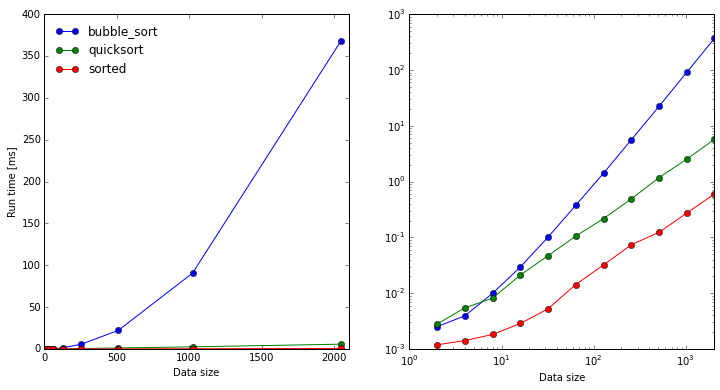

In [41]:
plt.rcParams['figure.figsize'] = (12, 6)

plt.subplot(1,2,1)
for algname, times in sorted(sort_times.items()):
    plt.plot(data_length, times, 'o-', label=algname)
plt.xlabel('Data size')
plt.ylabel('Run time [ms]')
plt.xlim(0, 2100)
plt.legend(loc='upper left', frameon=False);

plt.subplot(1,2,2)
for algname, times in sorted(sort_times.items()):
    plt.loglog(data_length, times, 'o-', label=algname)
plt.xlabel('Data size')
plt.xlim(1, 2010);

- `bubble_sort` 
    - faster than `quicksort` for small data
    - quickly gets worse for data size $>10$ 
- `quicksort` 
    - 10 times slower than `sorted`
    - same scaling as `sorted` (lines are parallel in log-log-plot)
- See `sorting_benchmark_extended.ipynb` notebook for a more detailed discussion

## Profiling

- *Profiling* is the systematic investigation of *where* programs spend there time.
- You should always profile before optimizing: most guesses about where time is spent are wrong
- Experience shows that 10% of the code consume 90% of the time: focus on those 10%



### Profiling by function

- Profiling by function shows us how much time is spent in each function
- Supported in Python by [cProfile](http://docs.python.org/2/library/profile.html) package

In [42]:
import cProfile
cProfile.run('quicksort([6, 4, 3, 8, 3, 10])')

         21 function calls (13 primitive calls) in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-30-5bf2a77f9848>:1(quicksort)
        4    0.000    0.000    0.000    0.000 <ipython-input-30-5bf2a77f9848>:14(_partition)
      9/1    0.000    0.000    0.000    0.000 <ipython-input-30-5bf2a77f9848>:6(_quicksort)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        4    0.000    0.000    0.000    0.000 {range}




- Running on such a small example gives very little information
- We can see that `range` was called 4 times
- `_quicksort` was called 9 times, in total, 1 time non-recursively 

In [43]:
import random as r
data = [r.random() for _ in range(1000000)]
cProfile.run('quicksort(data)')

         2666697 function calls (1333351 primitive calls) in 5.883 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.015    0.015    5.852    5.852 <ipython-input-30-5bf2a77f9848>:1(quicksort)
   666673    4.852    0.000    5.266    0.000 <ipython-input-30-5bf2a77f9848>:14(_partition)
1333347/1    0.572    0.000    5.837    5.837 <ipython-input-30-5bf2a77f9848>:6(_quicksort)
        1    0.031    0.031    5.883    5.883 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
   666673    0.414    0.000    0.414    0.000 {range}




- What does this data show us (note: precise numbers may differ below due to re-runs of the benchmark)?
    - `ncalls`: number of calls
        - for `_quicksort`, the one call is not recursive, all others recursive
        - the number of recursive `_quicksort` calls is twice the number of `_partition` calls
        - there is one `range` call per `_partition` call
        - all these numbers are consistent with our reading of the code
    - `tottime`: total time spent in a function
        - 5.1s were spent in `_partition`, about 83% of the total run time
        - 0.6s were spent in `_quicksort`, 0.4s in `range`
    - `percall`: time spent in function during a single call
    - `cumtime`: time spent by a function and all functions calling it
        - 6.092s: "module" is our call to quicksort
        - 6.071s: `quicksort(data)`
        - 6.061s: `_quicksort()`
        - 5.508s: `_partition()`
        - 0.421s: `range()`
- We can get information in different formats by writing data to file and then analysing it with the `pstats` package
- You can also run profiling directly in PyCharm

In [44]:
cProfile.run('quicksort(data)', 'quicksort.prof')

In [45]:
import pstats
p = pstats.Stats('quicksort.prof');   # reads data from file
p = p.strip_dirs();                   # remove directory information from file names
p.print_stats();                      # print statistics

Thu Nov 19 21:16:56 2015    quicksort.prof

         2666697 function calls (1333351 primitive calls) in 6.682 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
1333347/1    0.597    0.000    6.655    6.655 <ipython-input-30-5bf2a77f9848>:6(_quicksort)
   666673    5.537    0.000    6.058    0.000 <ipython-input-30-5bf2a77f9848>:14(_partition)
        1    0.000    0.000    0.000    0.000 {len}
        1    0.007    0.007    6.662    6.662 <ipython-input-30-5bf2a77f9848>:1(quicksort)
        1    0.020    0.020    6.682    6.682 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
   666673    0.520    0.000    0.520    0.000 {range}




##### Choose sorting criterium

In [46]:
p.sort_stats('cumulative').print_stats()  # print sorted by cumulative time

Thu Nov 19 21:16:56 2015    quicksort.prof

         2666697 function calls (1333351 primitive calls) in 6.682 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.020    0.020    6.682    6.682 <string>:1(<module>)
        1    0.007    0.007    6.662    6.662 <ipython-input-30-5bf2a77f9848>:1(quicksort)
1333347/1    0.597    0.000    6.655    6.655 <ipython-input-30-5bf2a77f9848>:6(_quicksort)
   666673    5.537    0.000    6.058    0.000 <ipython-input-30-5bf2a77f9848>:14(_partition)
   666673    0.520    0.000    0.520    0.000 {range}
        1    0.000    0.000    0.000    0.000 {len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




<pstats.Stats instance at 0x10aaa2dd0>

##### Print who has called which function how often

In [47]:
p.print_callers()

   Ordered by: cumulative time

Function                                          was called by...
                                                      ncalls  tottime  cumtime
<string>:1(<module>)                              <-
<ipython-input-30-5bf2a77f9848>:1(quicksort)      <-       1    0.007    6.662  <string>:1(<module>)
<ipython-input-30-5bf2a77f9848>:6(_quicksort)     <-       1    0.000    6.655  <ipython-input-30-5bf2a77f9848>:1(quicksort)
                                                   1333346/2    0.597    6.430  <ipython-input-30-5bf2a77f9848>:6(_quicksort)
<ipython-input-30-5bf2a77f9848>:14(_partition)    <-  666673    5.537    6.058  <ipython-input-30-5bf2a77f9848>:6(_quicksort)
{range}                                           <-  666673    0.520    0.520  <ipython-input-30-5bf2a77f9848>:14(_partition)
{len}                                             <-       1    0.000    0.000  <ipython-input-30-5bf2a77f9848>:1(quicksort)
{method 'disable' of '_lsprof.Profiler'

<pstats.Stats instance at 0x10aaa2dd0>

##### Print which functions a function has called

In [48]:
p.print_callees()

   Ordered by: cumulative time

Function                                          called...
                                                      ncalls  tottime  cumtime
<string>:1(<module>)                              ->       1    0.007    6.662  <ipython-input-30-5bf2a77f9848>:1(quicksort)
<ipython-input-30-5bf2a77f9848>:1(quicksort)      ->       1    0.000    6.655  <ipython-input-30-5bf2a77f9848>:6(_quicksort)
                                                           1    0.000    0.000  {len}
<ipython-input-30-5bf2a77f9848>:6(_quicksort)     -> 1333346/2    0.597    6.430  <ipython-input-30-5bf2a77f9848>:6(_quicksort)
                                                      666673    5.537    6.058  <ipython-input-30-5bf2a77f9848>:14(_partition)
<ipython-input-30-5bf2a77f9848>:14(_partition)    ->  666673    0.520    0.520  {range}
{range}                                           ->
{len}                                             ->
{method 'disable' of '_lsprof.Profiler' obj

<pstats.Stats instance at 0x10aaa2dd0>

### Line-wise profiling

- Often, we need more information: Where in `_partition` is time spent?
- Line profiling can help
- Python tool: [line_profiler](https://github.com/rkern/line_profiler)
- See also [IPython Cookbook](http://nbviewer.ipython.org/github/davidrpugh/cookbook-code/blob/master/notebooks/chapter04_optimization/03_linebyline.ipynb)
- We need to import `line_profiler` as IPython extension
- We need to specify which functions to profile
- We use smaller data, since line profiling slows things considerably
- Results are shown at the bottom of the window
- **Note**: Requires installation of `line_profiler`
    - Anaconda Python: `conda install line_profiler`
    - Other Pythons: `pip install line_profiler`

In [49]:
%load_ext line_profiler

In [50]:
data2 = [r.random() for _ in range(100000)]
%lprun -f _quicksort -f _partition quicksort(data2)

##### Results from line-wise profiling

The following results are copied in from the separate frame in which results are shown:

    Timer unit: 1e-06 s

    Total time: 5.15528 s
    File: <ipython-input-31-5bf2a77f9848>
    Function: _quicksort at line 6

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
         6                                           def _quicksort(data, left, right):
         7    133415        48213      0.4      0.9      if right - left < 2:
         8     66708        19860      0.3      0.4          return
         9                                           
        10     66707      5029820     75.4     97.6      pivot_idx = _partition(data, left, right)
        11     66707        29349      0.4      0.6      _quicksort(data, left, pivot_idx)
        12     66707        28039      0.4      0.5      _quicksort(data, pivot_idx + 1, right)

    Total time: 2.73392 s
    File: <ipython-input-31-5bf2a77f9848>
    Function: _partition at line 14

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
        14                                           def _partition(data, left, right):
        15     66707        23021      0.3      0.8      if not left < right:
        16                                                   return None
        17                                           
        18     66707        23738      0.4      0.9      right -= 1  
        19     66707        21913      0.3      0.8      pivot_idx = left
        20     66707        23406      0.4      0.9      pivot_val = data[pivot_idx]
        21                                           
        22     66707        30984      0.5      1.1      data[pivot_idx], data[right] = data[right], data[pivot_idx]
        23     66707        21906      0.3      0.8      store_idx = left
        24                                           
        25   2138886       799513      0.4     29.2      for i in range(left, right):
        26   2072179       808267      0.4     29.6          if data[i] < pivot_val:
        27   1123448       526545      0.5     19.3              data[i], data[store_idx] = data[store_idx], data[i]
        28   1123448       402134      0.4     14.7              store_idx += 1
        29     66707        31686      0.5      1.2      data[store_idx], data[right] = data[right], data[store_idx]
        30                                           
        31     66707        20805      0.3      0.8      return store_idx
        
##### Comments

- `_quicksort()` line 8 is executed in (almost) exactly half the cases, because it is exeucted one every time the recursion terminates. For a balanced recursion tree, with $m$ levels, we have $2^m$ such recursion leaves. The total number of inner nodes of the tree are $\sum_{k=0}^{m-1} 2^k=2^m-1$.
- The loop header, line 25, is entered exactly 66.646 times more often than the first line in the loop body, line 26. This is precisely the time of loop iterations and reflects the final visit to the loop condition which raises `StopIteration` and ends the loop.
- In `_partition()` line 27-28, data is swapped approximately 50% of the time. This is plausible for random data.